Copyright Optimizing Mind 2023
Optimizing Mind Jupyter notebook for benchmarking transfer learning.
This code compares transfer learning for cats and dogs and is based on the tesor flow tutorial and code.
The code: 
1) initiates the Optimizing Mind API 
2) downloads cats dogs data 
3) runs the tensor flow example learning code
4) runs OM API learning on the exact same data samples as in (3)
5) plots verification and learning curves

Optimizing Mind User Guide for API https://docs.google.com/document/d/1Wc2j1Uq6euhuYCsEbvcC8V5xvr5Z4JBf
Steps to run Optimizing Mind API
1) Register and obtain API token https://om-learn-api.azurewebsites.net/
2) copy your token and place in \<token\>

Changes from original TF tutorial code:
1) top layer changed from binary to multiclass to allow for multiple labels (no penalty in performance)
2) batch size is changed from the original 32 to 1 in order to be able to better observe OM learning curve (no penalty in performance)
3) TF training loop code changed to a manual one (for loop instead of fit)
4) options added for different datasets
5) options added for different bases
original code: https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/images/transfer_learning.ipynb

Note code is slow because lots of validation is run on both models, but it produces detailed learning curves

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow import keras
import time
import json
import requests

In [2]:
def Send_to_API(base_name,dataset_name, top_layer_inputs, labels,num_outputs,verbose=False):
    try:
        top_layer_inputsL = top_layer_inputs.tolist() # inputs
        labelsL = labels.tolist() #labels
        num_outputsL = str(num_outputs) 

    except Exception as e:
        if verbose: print(e)
        return(e) 

    username = os.getenv('JUPYTERHUB_USER')
    payload = {"model_name": "test_model005",'inputs': top_layer_inputsL, 'labels': labelsL,'num_outputs':num_outputsL}
    headers = { 'content-type': 'application/json', 'accept': 'application/json','Authorization':'Bearer <token>' }  # <token>

    r = requests.post(url = 'https://om-learn-api.azurewebsites.net/api/train/', data = json.dumps(payload), headers=headers)
    result = json.loads(r.text)
    return(result)

In [3]:
def Get_from_API(data): # within compiled code
    weights = np.array(data["result"]) 
    return(weights)

In [4]:
from datetime import datetime
now=datetime.now()
date_time=now.strftime("%m-%d-%Y")

In [5]:
date_time

'10-05-2023'

In [6]:
print(tf.__version__)

2.12.0


In [7]:
BATCH_SIZE =1 #32   #1
IMG_SIZE = (160, 160)

In [8]:
# sets up the directories automatically  
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)

In [9]:
# Datasets to benchmark

dataset_name='cats_and_dogs_filtered'  #originalTF notebook dataset
#dataset_name='Animals_filtered'  # 50 animal dataset
#dataset_name='fowl_data' # from https://learn.microsoft.com/en-us/azure/machine-learning/how-to-train-pytorch

PATH2 = os.path.join(os.path.dirname(path_to_zip),dataset_name )    
print(PATH2)

C:\Users\Tsvi\.keras\datasets\cats_and_dogs_filtered


In [10]:
train_dir = os.path.join(PATH2, 'train')
validation_dir = os.path.join(PATH2, 'validation')

print(PATH2,'\n',train_dir,'\n',validation_dir)

C:\Users\Tsvi\.keras\datasets\cats_and_dogs_filtered 
 C:\Users\Tsvi\.keras\datasets\cats_and_dogs_filtered\train 
 C:\Users\Tsvi\.keras\datasets\cats_and_dogs_filtered\validation


In [11]:
train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                                         shuffle=True,
                                                                         batch_size=BATCH_SIZE,
                                                                         image_size=IMG_SIZE)

validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                              shuffle=True,
                                                                              batch_size=BATCH_SIZE,
                                                                              image_size=IMG_SIZE)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [12]:
print("Dataset class names:", train_dataset.class_names)

Dataset class names: ['cats', 'dogs']


In [13]:
class_names = train_dataset.class_names
num_outputs=len(class_names)
print('number of classes and outputs:',num_outputs)

number of classes and outputs: 2


In [14]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [15]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 800
Number of test batches: 200


In [16]:
print('Number of training batches: %d' % tf.data.experimental.cardinality(train_dataset))

Number of training batches: 2000


In [17]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [18]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

In [19]:
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)

In [20]:
initial_epochs = 1 #10  

In [21]:
IMG_SHAPE = IMG_SIZE + (3,)

In [22]:
# choose base

MODEL = 'MobileNetV2'
#MODEL = 'ResNet50'


In [23]:
if MODEL=='MobileNetV2':
    preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
    base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                                include_top=False,
                                                weights='imagenet')
elif MODEL=='ResNet50':
    preprocess_input = tf.keras.applications.resnet50.preprocess_input
    base_model = tf.keras.applications.ResNet50(input_shape=IMG_SHAPE,
                                                include_top=False,
                                                weights='imagenet')
else:
    error("Model Not supported")


In [24]:
base_model.trainable = False

In [25]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 20, 20, 144)  576        ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_depthwise_relu (ReLU)  (None, 20, 20, 144)  0           ['block_3_depthwise_BN[0][0]']   
                                                                                                  
 block_3_project (Conv2D)       (None, 20, 20, 32)   4608        ['block_3_depthwise_relu[0][0]'] 
                                                                                                  
 block_3_project_BN (BatchNorma  (None, 20, 20, 32)  128         ['block_3_project[0][0]']        
 lization)

 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 10, 10, 384)  0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 10, 10, 384)  3456       ['block_7_expand_relu[0][0]']    
 nv2D)                                                                                            
                                                                                                  
 block_7_depthwise_BN (BatchNor  (None, 10, 10, 384)  1536       ['block_7_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_7_d

 block_10_project_BN (BatchNorm  (None, 10, 10, 96)  384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 10, 10, 576)  55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_expand_BN (BatchNorma  (None, 10, 10, 576)  2304       ['block_11_expand[0][0]']        
 lization)                                                                                        
                                                                                                  
 block_11_expand_relu (ReLU)    (None, 10, 10, 576)  0           ['block_11_expand_BN[0][0]']     
                                                                                                  
 block_11_

                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 5, 5, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 5, 5, 160)    153600      ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_project_BN (BatchNorm  (None, 5, 5, 160)   640         ['block_14_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_14_add (Add)             (None, 5, 5, 160)    0           ['block_13_project_BN[0][0]',    
                                                                  'block_14_project_BN[0][0]']    
          

In [26]:
# the original adds 2d global_average_pooling2d layer to make the base layer ready for classification.  
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

In [27]:
# set up learning and top layer, changed from binary to multiclass so softmax added to top
final_output_layer=tf.keras.layers.Softmax()

In [28]:
# This is the multiclass equivalent to original transfer learning network  
prediction_layer4 = tf.keras.layers.Dense(num_outputs)  # change1 from original: I make num_outputs outputs
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = prediction_layer4(x)    # adds the 49 nodes
outputs = final_output_layer(x)  # change2: adds softmax
orig_TF_paradigm_model = tf.keras.Model(inputs, outputs)   # this is now the traditional leanring network

In [29]:
# Change 3:SparseCategoricalCrossentropy from BinaryCrossentropy because it is multiclass

base_learning_rate = 0.0001
orig_TF_paradigm_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),  #loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'],
              run_eagerly=True,) # Now I compile it.  

In [30]:
orig_TF_paradigm_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

In [31]:
# create the version of the base model called model_with_av_layer that will feed inputs to OM layer 
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
outputs = global_average_layer(x)
#outputs = prediction_layer(x)   # It is basically the same as the original notebook but no prediction layer
model_with_av_layer = tf.keras.Model(inputs, outputs) 


In [32]:
model_with_av_layer.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 160, 160, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 160, 160, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                           

In [33]:
num_inputs=model_with_av_layer.output.shape[1]  

In [34]:
# this is an equivalent TF model that will recieve the OM weights
prediction_layer2 = tf.keras.layers.Dense(num_outputs)  # top nodes
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = prediction_layer2(x)  # nodes whose weights I will be changed by om
outputs = final_output_layer(x)  #softmax
tf_model_tobe_trained_by_OM = tf.keras.Model(inputs, outputs)


In [35]:
#it needs compile if I do validation but I never really do any learning so most of this doesnt really matter
base_learning_rate = 0.0001
tf_model_tobe_trained_by_OM.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),  #loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'],
              run_eagerly=True,) # needs to be added to prevent execution optimization (not data optimiziation)

In [36]:
tf_model_tobe_trained_by_OM.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv_2 (TFOpLamb  (None, 160, 160, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_2 (TFOpLam  (None, 160, 160, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                           

In [37]:
# does not validate at every point for graphing (otherwise things take forever)
# test first 30 data points only.  This takes long enough verification is done in for each model independently
validate_points=np.concatenate([np.arange(0,30,3)+2])

# extended validations used to graph charts in Optimizing Mind video and briefs
#validate_points=np.concatenate([np.arange(30),np.arange(30,40,2),np.arange(40,60,3),np.arange(60,100,5),np.arange(100,300,7),np.arange(300,700,10),np.arange(700,1500,15),np.arange(1500,3000,20)])

In [38]:
len(validate_points)

10

In [39]:
validate_points

array([ 2,  5,  8, 11, 14, 17, 20, 23, 26, 29])

In [40]:
max_sample=max(validate_points)

In [41]:
# variables to store performance of batches for both approaches
num_batches_in_train_dataset=len(train_dataset)              # number of batches in train_dataset
print("num of data of train batches in a single epoch",num_batches_in_train_dataset,"batch size =",BATCH_SIZE,"epochs=",initial_epochs)
OM_learn_Vacc=[] 
tf_learn_Vacc=[]

num of data of train batches in a single epoch 2000 batch size = 1 epochs= 1


In [42]:
# store baselines before learn
store_baselines_before_learning=True
if store_baselines_before_learning:
    loss_, accuracy_ = orig_TF_paradigm_model.evaluate(validation_dataset)
    print('validation of TF before train on new',accuracy_)
    tf_learn_Vacc.append(accuracy_) #store data

    loss0, accuracy_OMTF = tf_model_tobe_trained_by_OM.evaluate(validation_dataset)  # it is validated and run just like the original TF
    print('validation of OM on NEW data before train on new',accuracy_OMTF/100)
    OM_learn_Vacc.append(accuracy_OMTF/100) 
    
    # add one more zero point and increase the index of everything by 1 to test before learning
    graph_points=list(validate_points.copy()+1)
    graph_points.insert(0,0)
else:
    graph_points=list(validate_points.copy())


800/800 [==============================] - 117s 145ms/step - loss: 0.6924 - accuracy: 0.5400
validation of TF before train on new 0.5400000214576721
800/800 [==============================] - 116s 145ms/step - loss: 0.6601 - accuracy: 0.6100
validation of OM on NEW data before train on new 0.006100000143051148


In [43]:
initial_epochs=1

In [44]:
verbose=False
labels_presented=[]

In [45]:
for j in range(initial_epochs):
    if j>0:  #update graph points if doing more than one epoch
        validate_points=np.concatenate([np.arange(0,3000,30)])
        graph_points[num_stored:]=[]
        graph_points=graph_points+list(validate_points.copy()+len(labels_presented)+1)   #need to figure out graphing stuff

    for i, data in train_dataset.enumerate():   
        print(i)
        if i>max_sample:
            break
            
        labels_presented.append(data[1])  # store record of labels presented
                
        #the original learning        
        batch_logs = orig_TF_paradigm_model.train_step(data)
                
        # prepare data to send out to OM.        
        net_out = model_with_av_layer.predict_on_batch(data[0])  # run through base layer to have data ready for OM
        
        
        # call to the API
        json_back=Send_to_API(MODEL,dataset_name, net_out, data[1].numpy(),num_outputs, verbose=verbose)
        
        
        outfrom_Get_from_API=Get_from_API(json_back) #extract weights from API results
        
        u_model=np.array(outfrom_Get_from_API).T
        
        
        if verbose: 
            print("input size: ",net_out.shape,"label size: ",data[1].shape)
            print("label is:",np.array(data[1]))
            print("label is:",data[1].numpy())
            print("net_out",net_out)
            print("num_outpus",num_outputs)
            print("Json back in notebook",json_back)
            print("outfrom_Get_from_API",outfrom_Get_from_API)
            print("u_model.shape",u_model.shape)
        
        # put weights that come back into final OM generated transfer learning network: 
        tf_model_tobe_trained_by_OM.trainable_weights[0].assign(tf.Variable(np.float32(u_model)))     #OMmodel.u_model.T))) 
        # this is now the TF equivalent of OM learned net 
        
        # validation code run in specified validation points
        if i in validate_points:  # minimizing number of validations because it takes too long
        
            # validating TF learned top layer
            loss_, accuracy_ = orig_TF_paradigm_model.evaluate(validation_dataset)

            # adding TF accuracies to the record
            tf_learn_Vacc.append(accuracy_)  
            
            # validating OM learned top layer but equivalent net to TF
            loss0, accuracy_OMTF = tf_model_tobe_trained_by_OM.evaluate(validation_dataset)  # it is validated and run just like the original TF

            OM_learn_Vacc.append(accuracy_OMTF)

            print("Training: Batch {}, Epoch {}, {} entries accuracy of OM {} and TF {} ".format(i,j, len(data[0]), np.round(OM_learn_Vacc[-1],4),np.round(accuracy_,4)))
            
    
    num_stored=len(OM_learn_Vacc)
    

tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
800/800 [==============================] - 137s 172ms/step - loss: 0.6463 - accuracy: 0.9075
Training: Batch 2, Epoch 0, 1 entries accuracy of OM 0.9075 and TF 0.5387 
tf.Tensor(3, shape=(), dtype=int64)
tf.Tensor(4, shape=(), dtype=int64)
tf.Tensor(5, shape=(), dtype=int64)
800/800 [==============================] - 128s 160ms/step - loss: 0.6130 - accuracy: 0.9638
Training: Batch 5, Epoch 0, 1 entries accuracy of OM 0.9638 and TF 0.54 
tf.Tensor(6, shape=(), dtype=int64)
tf.Tensor(7, shape=(), dtype=int64)
tf.Tensor(8, shape=(), dtype=int64)
800/800 [==============================] - 87s 108ms/step - loss: 0.5951 - accuracy: 0.9362
Training: Batch 8, Epoch 0, 1 entries accuracy of OM 0.9362 and TF 0.5487 
tf.Tensor(9, shape=(), dtype=int64)
tf.Tensor(10, shape=(), dtype=int64)
tf.Tensor(11, shape=(), dtype=int64)
800/800 [==============================] - 76s 95ms/step - loss: 

In [46]:
print(len(OM_learn_Vacc))

11


In [47]:
num_stored=len(OM_learn_Vacc)

In [48]:
# indicate when all animals are presented at least once
all_presented=1
while len(np.unique(labels_presented[0:all_presented])) != len(np.unique(labels_presented)):
    all_presented=all_presented+1
all_presented=np.where(np.array(graph_points) >= all_presented)[0][0]   #first index where all presented
print('first validation run after all animals were presented:',all_presented,'\nwhich begins with training instance',graph_points[all_presented])

first validation run after all animals were presented: 1 
which begins with training instance 3


In [87]:
num_stored=len(graph_points)

In [88]:
grange=int(graph_points[num_stored-1]*.02)     #90  #31 #90 #121  # choosing a nice zoom range
if grange==0:
    grange=num_stored-1
maxpoint=max(graph_points[0:grange])
print(maxpoint)

27


In [89]:
maxpoint

27

first 30 plots


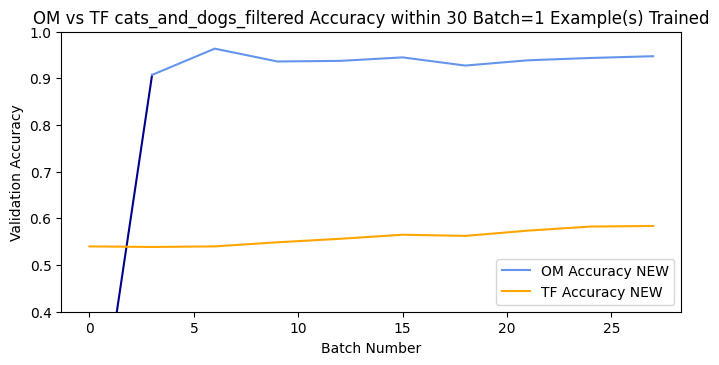

Labels   [[1 1 0 0 1 0 1 0 1 0]]


In [90]:
# zoomed figure
print('first',graph_points[grange],'plots')

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)

plt.plot(graph_points[0:(all_presented+1)],OM_learn_Vacc[0:(all_presented+1)],color='darkblue')
plt.plot(graph_points[all_presented:grange],OM_learn_Vacc[all_presented:grange],color='cornflowerblue', label='OM Accuracy NEW')
plt.plot(graph_points[0:grange],tf_learn_Vacc[0:grange],color='orange', label='TF Accuracy NEW')



plt.legend(loc='lower right')
plt.ylabel('Validation Accuracy')
#plt.ylim([min(plt.ylim()),1])
plt.ylim([0.4,1.0])
plt.title("OM vs TF {} Accuracy within {} Batch={} Example(s) Trained".format(dataset_name,graph_points[grange],BATCH_SIZE))

plt.xlabel('Batch Number')
plt.show()
print('Labels  ',np.array(labels_presented)[0:grange].T)